# Box-counting

## Box-counting for 1D sets

We consider a set $S = \{ ..., \{ p_i, \mu_i \}, ... \}$ covering an interval $I$ on the real line. We cover $I$ with boxes of equal size. 
We count the point $p$ in the box $b$ if 
$$ b \epsilon \leq p  < (b+1)\epsilon, $$ 
where $\epsilon$ in the size of the boxes. By convention the last point is in the last box.
This is equivalent to saying that point $p$ is in the $b^\text{th}$ box (labelling from small to large absissas) iff
$$ \text{floor}\left( \frac{p}{\epsilon} \right) = b. $$

We can either keep $\epsilon$ fixed, say $\epsilon = 1$, and vary the length of $I$, or keep the length of $I$ fixed and vary $\epsilon$. We are going to adopt this latter point of view.

We define the $q$-weight, or partition function, at length scale $\epsilon$:
$$ \chi_q(\epsilon) = \sum_b \left( \mu_\epsilon(b) \right)^q $$
where $\mu_\epsilon(b)$ is the weight of the box $b$:
$$ \mu_\epsilon(b) = \sum_{i \text{ in } b} \mu_i  $$.

Multifractal thermodynamic theory tells us that the $q$-weight is related to the fractal dimensions in the same way than the partition function of a thermodynamic system is related to its free energy:
$$ \tau_q \sim \frac{\log \chi_q(\epsilon)}{\log \epsilon}$$
where we take $\epsilon \rightarrow 0$ limit, equivalent to the thermodynamic limit of a thermodynamic system.

## Box size specification

The box size can be written as $\epsilon = \delta^{-n} L$. If $I$ is of length $L$, then if either $\delta$ or $n$ are not integers, the box size will not divide 1, ie part of the last box will fall out of $I$.
This generally means that the $q$-weight will be badly estimated. 

## Accuracy

With double floats (default python on the computer I wrote this!), the fractal dimensions are typically accurate up to 2 digits.

In [21]:
import numpy as np
from scipy import linalg, stats
import matplotlib.pyplot as plt
import math
from cmath import exp
import time
%matplotlib inline

In [22]:
s = np.arange(0,10,1.)

In [23]:
# rescale S between m and M
def rescale(s,m,M):
    return (M-m)*(s-s[0])/(s[-1]-s[0])+m

In [68]:
""" compute the q-weigth (or partition function) of S """

# s: set of absissas, w: set of corresponding weigths
def qWeight(s, w, epsilon, q):
    # checks
    if len(s) != len(w): return("the sets of absissas and weights are of unequal lenths")
    #if sum(w) != 1.: return("the weights are not normalized to 1")
    
    # rescale the set between 0 and 1
    s = rescale(s, 0., 1.)
    # total q-weight
    qw = 0
    # weight in the current box
    curw = w[0]
    # label of the current box
    b = 0
    
    for i in range(1,len(s)-1):
        bnew = math.floor(s[i]/epsilon)
        # if the current point is in the same box as the one juste at its left, add its weigth to the total weight in the current box
        if bnew == b:
            curw += w[i]
        # else the current point is in a new box, add the last box weight to the total q-weight, set the current label to this box
        else:
            qw += curw**q
            curw = w[i]
            b = bnew
   
    # the last point is in the last box
    nb = math.floor(1./epsilon)
    # the last point is alone in the last box
    if b < nb-1:
        qw += curw**q
        qw += w[-1]**q
    # there is at least 2 points in the last box
    elif b == nb-1:
        curw += w[-1]
        qw += curw**q
    # some part of the last box falls outside of I
    else: print('Box size '+str(epsilon)+' does not divide 1! Adding the data point nevertheless')
    
    return qw

In [69]:
qWeigth(s,[1./len(s) for p in s],0.01,1)

0.999999999999999

In [70]:
sum([1./len(s) for p in s])

0.999999999999991

## Application to the Fibonacci Hamiltonian

We consider Fibonacci tight-binding Hamiltonian with pure hopping.

We can compute the fractal dimensions of the wavefunctions. We then take the positions and the weights to be:
$$ p_i = x_i, \text{ and } w_i =|\psi_E(x_i)|^2  $$
where $\psi_E(x_i)$ is the coefficient at site $i$ of position $x_i$ of the wavefunction associated to the energy $E$.

We can also compute the fractal dimensions of the spectrum. This time $p_i$ is the position of the band $i$, and $w_i$ is the width of this band.

We can as well compute the fractal dimensions of the local spectral measure $\mu_{x,x}(E)$. $p_i$ is still the position of the band $i$, and $w_i$ is the local density of states at position $x$ and energy in the band $i$.

In [46]:
""" build the Fibonacci tight-binding hamiltonian """

# couplings
tw = 0.5
ts = 1.

# compute Fibonacci numbers
def fib(n):
    a, b = 0, 1
    for i in range(n):
        a, b = b, a + b
    return a

# inverse golden ratio
om = 2./(1.+math.sqrt(5))

# size
n = 15
L = fib(n)

# i = oddNumber*2**intExp(i)
def intExp(i):
    exp = 0
    while(i%2 == 0):
        i/=2
        exp+=1
    return exp        

# jump amplitudes
def jump(i):
    fibi = int(om*(i+1)) - int(om*i) # an integer taking values 0 or 1 occordingly to Fibonacci sequence
    if(fibi < 1):return ts
    else:return tw

# build the hamiltonian (free boundary conditions)
h = np.zeros((L,L))
for i in range(L-1): 
    h[i,i+1] = jump(i+1)
    h[i+1,i] = h[i,i+1]
    
# construct the "band", to use eig_banded method
# there is 1 band above the diagonal, so a_band has shape (2,L)
a_band = np.zeros((2,L))
for i in range(L-1): a_band[0,i+1] = h[i,i+1]

In [47]:
""" compute the eigenvalues """

# eigensystem for a banded hermitian matrix (our case!)
val, vec = linalg.eig_banded(a_band)

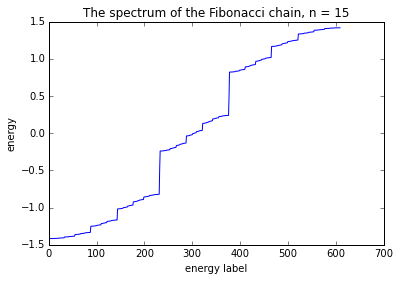

In [48]:
""" wow, such spectrum! much gaps! """

plt.title('The spectrum of the Fibonacci chain, n = ' + str(n))
plt.xlabel('energy label')
plt.ylabel('energy')
#plt.axis([0,L+1,-2.,2.])
plt.plot(val)
plt.show()

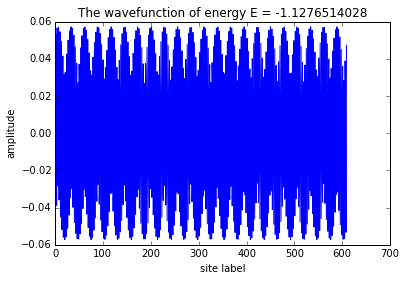

In [159]:
""" plot a wavefunction """

e = 188
plt.title('The wavefunction of energy E = ' + str(val[e]))
plt.xlabel('site label')
plt.ylabel('amplitude')
#plt.axis([0,L+1,-2.,2.])
plt.plot(vec[:,e])
plt.show()

In [66]:
""" Fractal dimensions of the wavefunctions """

# choose an energy
e = 200
# position set
s = np.arange(0,L,1.)
# weight set
w = abs(vec[:,e])**2

In [71]:
qWeight(s, w, 1.,0)

1.0

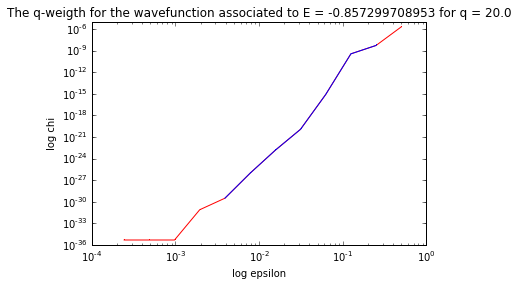

In [72]:
""" Fractal dimensions of the wavefunctions """

q = 20.

epsilonRange = 2**np.arange(-12.,0.,1.)
qwList = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange]

epsilonRange2 = 2**np.arange(-8.,-1.,1.)
qwList2 = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange2]

plt.title('The q-weigth for the wavefunction associated to E = ' + str(val[e]) + ' for q = ' + str(q))
plt.xlabel('log epsilon')
plt.ylabel('log chi')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(epsilonRange, qwList,'-,r',markersize=3.)
plt.loglog(epsilonRange2, qwList2,'-,b',markersize=3.)
plt.show()

# data in log-log scale
logQW = [math.log(qw) for qw in qwList2]
logEps = [math.log(eps) for eps in epsilonRange2]

slope, intercept, r_value, p_value, std_err = stats.linregress(logEps,logQW)

In [73]:
slope, std_err

(12.40336477705516, 0.66810531405401907)

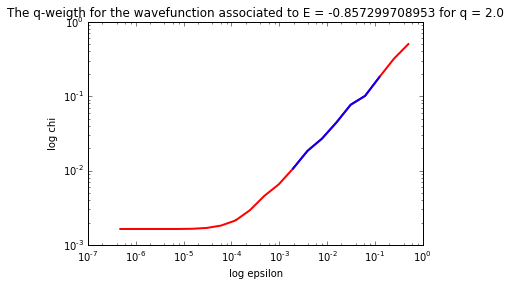

In [74]:
""" Fractal dimensions of the spectrum """

# positions are energy levels
s = val
# weights are uniform
w = [1./len(val) for e in val]

""" data regression """

q = 2.

epsilonRange = 2**np.arange(-21.,0.,1.)
qwList = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange]

epsilonRange2 = 2**np.arange(-9.,-2.,1.)
qwList2 = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange2]

plt.title('The q-weigth for the wavefunction associated to E = ' + str(val[e]) + ' for q = ' + str(q))
plt.xlabel('log epsilon')
plt.ylabel('log chi')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(epsilonRange, qwList,'-,r',markersize=3., linewidth=2.)
plt.loglog(epsilonRange2, qwList2,'-,b',markersize=3., linewidth=2.)
plt.show()

# data in log-log scale
logQW = [math.log(qw) for qw in qwList2]
logEps = [math.log(eps) for eps in epsilonRange2]

slope, intercept, r_value, p_value, std_err = stats.linregress(logEps,logQW)

In [75]:
slope, std_err, r_value

(0.667469485124493, 0.018603135659404541, 0.99806363765201556)

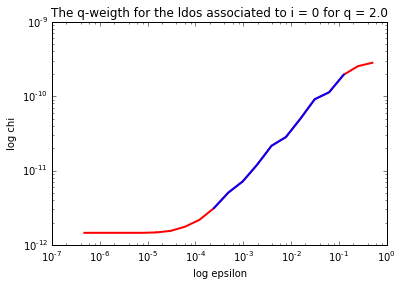

In [76]:
""" Fractal dimensions of the local spectral measure """

# position along the chain
i = 0
# positions are energy levels
s = val
# weights are the local density of states at i
w = [abs(vec[i,e])**2 for e in val]

""" data regression """

q = 2.

epsilonRange = 2**np.arange(-21.,0.,1.)
qwList = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange]

epsilonRange2 = 2**np.arange(-12.,-2.,1.)
qwList2 = [qWeight(s, w, epsilon, q) for epsilon in epsilonRange2]

plt.title('The q-weigth for the ldos associated to i = ' + str(i) + ' for q = ' + str(q))
plt.xlabel('log epsilon')
plt.ylabel('log chi')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(epsilonRange, qwList,'-,r',markersize=3., linewidth=2.)
plt.loglog(epsilonRange2, qwList2,'-,b',markersize=3., linewidth=2.)
plt.show()

# data in log-log scale
logQW = [math.log(qw) for qw in qwList2]
logEps = [math.log(eps) for eps in epsilonRange2]

slope, intercept, r_value, p_value, std_err = stats.linregress(logEps,logQW)

In [77]:
slope, std_err, r_value

(0.66538339412000291, 0.013703757116991176, 0.99830764363420066)

## Averaged fractal dimensions of the wavefunctions

Now we wish to quantify the averaged fractal dimensions of the wavefunctions. 
For that, we define theoretically the averaged $q$-weight function:
$$ \overline{\chi}_q(L) = \langle \chi_{q, E}(L) \rangle = \frac{1}{L} \sum_{E} \chi_{q,E}(L) $$
where $\chi_{q,E}(L) = \sum_i |\psi_{i,E}|^2$.

The box-counting counterpart of $\chi_{q,E}(L)$ is $\chi_{q,E}(\epsilon)$.
We can either consider that 
$$ \overline{\chi}_q(\epsilon) = \langle \chi_{q, E}(\epsilon) \rangle $$
which seems natural, or that
$$ \log \overline{\chi}_q(\epsilon) = \langle \log \chi_{q, E}(\epsilon) \rangle $$
which is the definition used by Thiem.

In [78]:
""" Averaged q-weight function """

# averaged directly the q-weight function, not following Thiem
def av_qWeight(vec, epsilon, q):
    L = len(vec)
    # positions are uniform on the line
    s = np.arange(0,L,1.)
    # averaged q-weight
    avQw = 0
    # sum q-weights over energies
    for e in range(L):
        avQw += qWeight(s, abs(vec[:,e])**2, epsilon, q)
    return avQw/L

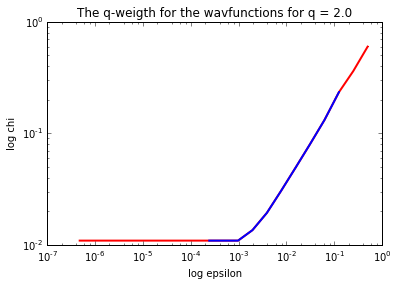

In [79]:
""" Averaged fractal dimensions of the wavefunctions """

""" data regression """

q = 2.

epsilonRange = 2**np.arange(-21.,0.,1.)
qwList = [av_qWeight(vec, epsilon, q) for epsilon in epsilonRange]

epsilonRange2 = 2**np.arange(-12.,-2.,1.)
qwList2 = [av_qWeight(vec, epsilon, q) for epsilon in epsilonRange2]

plt.title('The q-weigth for the wavfunctions for q = ' + str(q))
plt.xlabel('log epsilon')
plt.ylabel('log chi')
#plt.axis([0,L+1,-2.,2.])
plt.loglog(epsilonRange, qwList,'-,r',markersize=3., linewidth=2.)
plt.loglog(epsilonRange2, qwList2,'-,b',markersize=3., linewidth=2.)
plt.show()

# data in log-log scale
logQW = [math.log(qw) for qw in qwList2]
logEps = [math.log(eps) for eps in epsilonRange2]

slope, intercept, r_value, p_value, std_err = stats.linregress(logEps,logQW)